In [1]:
import os
import pandas as pd
import numpy as np
import json
import os
import random
import openpyxl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler, MaxAbsScaler, Normalizer, StandardScaler, PowerTransformer, QuantileTransformer
from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import silhouette_samples, silhouette_score
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer
# from yellowbrick.datasets import load_nfl
import benchmarks
import visualizations

import time
import IPython

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.linear_model import SGDOneClassSVM
from sklearn.kernel_approximation import Nystroem
from sklearn.cluster import DBSCAN
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import NearestNeighbors
# from kneed import KneeLocator, DataGenerator
import joblib

import transform_functions
# from .benchmarks import bench_k_means, bench_k_medoids
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]
# plt.figure(figsize=(15, 12))

In [2]:
# Load dataframe with average weighted value of loan segments
oscwd = os.getcwd()
df_entidad = pd.read_csv(os.path.join(oscwd, "data/GH.txt"), encoding="utf-8",
                            dtype = {
                                    'CODIGO': int, 'ENTIDAD': str, 
                                    'Grupo': float
                                    }
                                    # parse_dates=['Periodo'],
                            )
drop_ent = [11, 14, 29, 300] # list(df_entidad["CODIGO"][df_entidad["Grupo"]==8.0])
drop_digitales = [143, 158, 384, 45030]
drop_auto = [340, 44059, 44088, 44092, 44093, 44094, 44095, 44096, 44098, 44099]
drop_ent = drop_ent + drop_digitales + drop_auto

[0.9284142313040363, 0.04792162371369019, 0.022126750199499372, 0.0005987043033277316, 0.00043067361343134783, 0.00018514556228113572, 0.00010587610382139202, 7.380392759190591e-05, 6.092830582358232e-05, 3.2437382623296424e-05, 2.2717553079515647e-05, 1.3624084378153734e-05, 6.26214222617098e-06, 3.422397705465153e-06, 2.294571301085102e-06, 1.5048351835184869e-06]


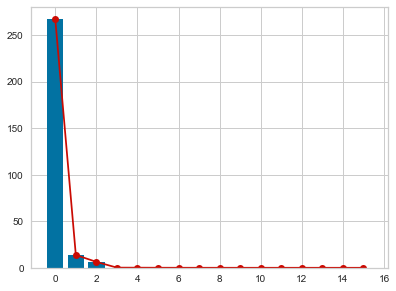

16
key_features index, [10, 14, 7, 3, 12, 8, 0, 8, 15, 13, 11, 2, 6, 1, 5, 9]
key_features, ['net_int_inc_tot_income', 'serv_rev_tot_inc', 'exp_dep_cap_loans', 'consumer_loans_assets', 'pers_cred_card_loans', 'loans_cap_assets', 'adv_curr_acc_disc_doc_loans', 'loans_cap_assets', 'titles_assets', 'roe', 'net_worth_assets', 'business_loans_assets', 'exp_assets', 'asset_tot_asset', 'deriv_assets', 'loans_cap_to_banks_assets']
key_features, ['net_int_inc_tot_income', 'serv_rev_tot_inc', 'exp_dep_cap_loans', 'consumer_loans_assets', 'pers_cred_card_loans', 'loans_cap_assets', 'adv_curr_acc_disc_doc_loans', 'titles_assets', 'roe', 'net_worth_assets', 'business_loans_assets', 'exp_assets', 'asset_tot_asset', 'deriv_assets', 'loans_cap_to_banks_assets']
number of significant features 1
Significant features = 3
Features used for clustering ['net_int_inc_tot_income', 'serv_rev_tot_inc', 'exp_dep_cap_loans']


In [3]:
data_kpis = pd.read_csv("data/kpis.csv")

start = 2008
end = 2018
data = transform_functions.get_mean_pivot_table(data_kpis, 0, 2, 1, 3, start, end)
data = data[[
            'ent', 
            'adv_curr_acc_disc_doc_loans', 'asset_tot_asset',
            'business_loans_assets', 'consumer_loans_assets', 'dep_cap_assets',
            'deriv_assets', 'exp_assets', 'exp_dep_cap_loans',
            'implied_lending_rate', 'implied_liable_rate', 'implied_spread',
            'liquidity_ratio', 'loan_avg_segment_asset', 'loans_cap_assets',
            'loans_cap_to_banks_assets', 'net_int_inc_tot_income',
            'net_worth_assets', 'pers_cred_card_loans', 'roe', 'serv_rev_tot_inc',
            'titles_assets'
            ]]
data = data.drop(columns=[
            #'adv_curr_acc_disc_doc_loans', 'asset_tot_asset',
            #'business_loans_assets', 
            #'consumer_loans_assets', 
            #'dep_cap_assets',
            #'deriv_assets', 
            #'exp_assets', 
            #'exp_dep_cap_loans',
            'implied_lending_rate', 'implied_liable_rate', 'implied_spread',
            'liquidity_ratio', 
            'loan_avg_segment_asset', 
            #'loans_cap_assets',
            #'loans_cap_to_banks_assets', 
            #'net_int_inc_tot_income',
            #'net_worth_assets', 'pers_cred_card_loans', 
            #'roe', 'serv_rev_tot_inc',
            #'titles_assets'
            ])
data_arr = data.iloc[:,1:].to_numpy()

pca = PCA()
pca.fit(data_arr)
df_pca_all = pca.transform(data_arr)
eigenvalues = pca.explained_variance_
eigen_perc = [float(c)/sum(eigenvalues) for c in eigenvalues]
print(eigen_perc)
plt.bar(np.arange(0,data.iloc[:,1:].shape[1],1), eigenvalues)
plt.plot(eigenvalues, "r")
plt.plot(eigenvalues, "ro")
plt.show()

# number of components
n_pcs= pca.components_.shape[0]
print(n_pcs)

# get the index of the most important feature on EACH component i.e. largest absolute value
# using LIST COMPREHENSION HERE
key_features_idx = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]
print("key_features index,", key_features_idx)

features = data.columns[1:]

# get the names
key_features = [features[key_features_idx[i]] for i in range(n_pcs)]
print("key_features,", key_features)

key_features_set = []
if len(key_features) > len(set(key_features)):
    for i, j in enumerate(key_features):
        if j not in key_features[0:i]:
            key_features_set.append(j)
    key_features =  key_features_set
else:
    pass

print("key_features,", key_features)

len_eigen_value = len([e for e in eigen_perc if e >= 0.05])
print("number of significant features", len_eigen_value)
n_features = len_eigen_value if len_eigen_value > 3 else 3
print("Significant features =", n_features)
sum_acc = np.cumsum(eigen_perc)

key_features = key_features[0:n_features]
print("Features used for clustering", key_features)

In [4]:
%%capture cap --no-stderr
print(f"banks_dropped {drop_ent}")

In [5]:
%%capture cap --no-stderr
with open('output/output.txt', 'w') as f:
    f.write(str(cap))

In [6]:
with open("data/kpi.json", "r") as kpi_json:
    kpi_list = json.load(kpi_json)
# list_kpis = most_important_names
data_kpis = pd.read_csv("data/kpis.csv")
# drop_ind = list_kpis
data_kpis = data_kpis[data_kpis["ind"].isin(key_features)]
data_kpis = data_kpis[~data_kpis["ent"].isin(drop_ent)]
kpis = data_kpis[data_kpis["ind"].isin(key_features)]["ind"].unique()
print(kpis)

['serv_rev_tot_inc' 'net_int_inc_tot_income' 'exp_dep_cap_loans']


In [7]:
%%capture cap --no-stderr
print(f"using_kpis {kpis}")

In [8]:
%%capture cap --no-stderr
with open('output/output.txt', 'a') as f:
    f.write(str(cap))

In [9]:
%%capture cap --no-stderr
start = 2008
end = 2018
data = transform_functions.get_mean_pivot_table(data_kpis, 0, 2, 1, 3, start, end)
df_corr, data = benchmarks.find_and_drop_correlated_features(data, labels_col="ent", threshold=0.7, drop=True, plot=True)
scaler_range = range(1,6)
outlier_algorithm_range = range(1,6)
for s in scaler_range:
    for o in outlier_algorithm_range:
        drop = True
        # df = benchmarks.drop_outliers(data=data, labels_col="ent", scaler=s, algorithm=o, drop=drop).reset_index()
        # df = df.drop(columns="index")
        init_list = ["random", "k-means++"]
        algorithm_list = ["lloyd", "elkan"]
        params = {
            'algorithm': algorithm_list[1], 
            'init': init_list[1], 
            'max_iter': 1000, 
            'n_clusters': 50, 
            'n_init': 10, 
            'random_state': None, 
            'tol': 0.0001, 
            'verbose': 0
        }
        df_scores = benchmarks.optimal_k(data, labels_col="ent", model="kmeans", params=params, max_k=2, min_k=2, scaler=s, threshold=0.8, drop=drop, algorithm=o, plot=True, min_max_items=[2, 20])

In [10]:
%%capture cap --no-stderr
with open('output/output.txt', 'a') as f:
    f.write(str(cap))

In [11]:
%%capture cap --no-stderr
start = 2008
end = 2018
data = transform_functions.get_mean_pivot_table(data_kpis, 0, 2, 1, 3, start, end)
df_corr, data = benchmarks.find_and_drop_correlated_features(data, labels_col="ent", threshold=0.7, drop=True, plot=True)
scaler_range = range(1,6)
outlier_algorithm_range = range(1,6)
for s in scaler_range:
    for o in outlier_algorithm_range:
        drop = True
        # df = benchmarks.drop_outliers(data=data, labels_col="ent", scaler=s, algorithm=o, drop=drop).reset_index()
        # df = df.drop(columns="index")
        init_list = ["random", "k-means++"]
        algorithm_list = ["lloyd", "elkan"]
        params = {
            'batch_size': 1024,
            'compute_labels': True,
            'init': init_list[0],
            'init_size': None,
            'max_iter': 10000,
            'max_no_improvement': 10,
            'n_clusters': 8,
            'n_init': 10,
            'random_state': None,
            'reassignment_ratio': 0.01,
            'tol': 0.0,
            'verbose': 0
        }
        df_scores = benchmarks.optimal_k(data, labels_col="ent", model="minibatch_kmeans", params=params, max_k=2, min_k=2, scaler=s, threshold=0.8, drop=drop, algorithm=o, plot=True, min_max_items=[2, 20])

In [12]:
%%capture cap --no-stderr
with open('output/output.txt', 'a') as f:
    f.write(str(cap))

In [13]:
%%capture cap --no-stderr
start = 2008
end = 2018
data = transform_functions.get_mean_pivot_table(data_kpis, 0, 2, 1, 3, start, end)
df_corr, data = benchmarks.find_and_drop_correlated_features(data, labels_col="ent", threshold=0.7, drop=True, plot=True)
scaler_range = range(1,6)
outlier_algorithm_range = range(1,6)
for s in scaler_range:
    for o in outlier_algorithm_range:
        drop = True
        # df = benchmarks.drop_outliers(data=data, labels_col="ent", scaler=s, algorithm=o, drop=drop).reset_index()
        # df = df.drop(columns="index")
        init_list = ["random", "heuristic", "k-medoids++", "build"]
        method_list = ["alternate", "pam"]
        params = {
            'init': init_list[2],
            'max_iter': 1000,
            'method': method_list[1],
            'metric': 'euclidean',
            'n_clusters': 8,
            'random_state': None
        }
        df_scores = benchmarks.optimal_k(data, labels_col="ent", model="kmedoids", params=params, max_k=2, min_k=2, scaler=s, threshold=0.8, drop=drop, algorithm=o, plot=True, min_max_items=[2, 20])

In [14]:
%%capture cap --no-stderr
with open('output/output.txt', 'a') as f:
    f.write(str(cap))

In [15]:
print[a]

NameError: name 'a' is not defined

In [ ]:
df_describe = data.iloc[:,1:].describe() # .to_excel(writer, sheet_name=f"describe_{s}")
fig, ax = plt.subplots()
ax.boxplot(data[data.columns[1:]], vert=False, showmeans=True, meanline=True,
        labels=data.columns[1:], patch_artist=True,
        medianprops={'linewidth': 2, 'color': 'purple'},
        meanprops={'linewidth': 2, 'color': 'red'})
plt.title(f"Boxplot --- Data not scaled")
#display(df_describe)

In [ ]:
%%capture cap --no-stderr
print("describe_not_scaled")
print(df_describe)

In [ ]:
%%capture cap --no-stderr
with open('output/output.txt', 'a') as f:
    f.write(str(cap))

In [ ]:
%%capture cap --no-stderr
df = benchmarks.drop_outliers(data=data, labels_col="ent", scaler=scaler, algorithm=algorithm, drop=drop).reset_index()
df = df.drop(columns="index")

In [ ]:
%%capture cap --no-stderr
with open('output/output.txt', 'a') as f:
    f.write(str(cap))

In [ ]:
df_describe = df.iloc[:,1:].describe() # .to_excel(writer, sheet_name=f"describe_{s}")
fig, ax = plt.subplots()
ax.boxplot(df[data.columns[1:]], vert=False, showmeans=True, meanline=True,
        labels=df.columns[1:], patch_artist=True,
        medianprops={'linewidth': 2, 'color': 'purple'},
        meanprops={'linewidth': 2, 'color': 'red'})
plt.title(f"Boxplot --- Data scaled")
#display(df_describe)

In [ ]:
%%capture cap --no-stderr
print("describe_scaled")
print(df_describe)

In [ ]:
%%capture cap --no-stderr
with open('output/output.txt', 'a') as f:
    f.write(str(cap))

In [ ]:
# df = data
(n_sample, n_features), n_digits = df.shape, 5
print(f"digits: {n_digits}, samples: {n_sample}, features: {n_features}")

In [ ]:
elbow_centers = PCA(n_components=2).fit_transform(df_elbow_centers)
df_elbow_centers = pd.DataFrame(elbow_centers, index=range(elbow_centers.shape[0]))
silhouette_centers = PCA(n_components=2).fit_transform(df_silhouette_centers)
df_silhouette_centers = pd.DataFrame(silhouette_centers, index=range(silhouette_centers.shape[0]))
df_pca = PCA(n_components=2).fit_transform(df.iloc[:,1:])
df_pca = pd.DataFrame(df_pca, columns=["pca1", "pca2"])
df_pca = pd.concat([df, df_pca], axis=1).iloc[:,[0,-2,-1]]

In [ ]:
%%capture cap --no-stderr
print(df_scores)
print("k_pred_elbow")
print(df_pred_elbow[["ent", "k_pred"]].sort_values(by=["k_pred", "ent"]))
print("k_pred_silhouette")
print(df_pred_silhouette[["ent", "k_pred"]].sort_values(by=["k_pred", "ent"]))
print("elbow_centers")
print(df_elbow_centers)
print("silhouette_centers")
print(df_silhouette_centers)
print("df_pca")
print(df_pca)

In [ ]:
%%capture cap --no-stderr
with open('output/output.txt', 'a') as f:
    f.write(str(cap))